In this notebook, we will concatenate all the game data into one data frame, and train an XGBoost model for whiff %. We will calculate stuff+ for generic fastball, off-speed, and breaking balls

First, we define the file path that contains all the data, and concatenate all csv files in the selected path 

In [207]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


Now that all the pitches have been combined into one large data frame, we can begin to subset the data based on pitch type. We first have to find out what pitch types there are, and classify each as a fastball, off-speed, or breaking ball

In [142]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()
print(tagged_pitch_types)

auto_pitch_types = all_pitches['AutoPitchType'].unique()
print(auto_pitch_types)

['Fastball' 'Slider' 'ChangeUp' 'Curveball' 'Cutter' 'Other' 'Undefined'
 'Sinker' 'Knuckleball' 'Splitter' 'FourSeamFastBall' 'TwoSeamFastBall'
 'OneSeamFastBall']
['Sinker' 'Four-Seam' 'Curveball' 'Changeup' 'Slider' 'Cutter' nan
 'Splitter' 'Other']


Now that we know what types of pitches there are, we can create the three desired subsets

In [143]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]
breaking_balls = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider','Curveball','Knuckleball'])]

print(fastballs.shape)
print(off_speed.shape)
print(breaking_balls.shape)

(152663, 167)
(31218, 167)
(80860, 167)


Now we have the three different data frames created, we can create a new column called 'Whiff' with a 1 if there is a swinging strike or a 0 if not.

In [144]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
breaking_balls['whiff'] = np.where(breaking_balls['PitchCall']=='StrikeSwinging',1,0)

0     0
1     0
3     0
4     0
5     0
8     0
9     0
10    0
13    0
14    0
Name: whiff, dtype: int32
6     0
7     0
11    0
40    0
41    0
55    0
56    0
69    0
72    0
84    0
Name: whiff, dtype: int32
2     0
12    0
19    0
21    1
22    0
29    0
32    0
35    0
36    0
39    0
Name: whiff, dtype: int32


C:\Users\charl\AppData\Local\Temp\ipykernel_10652\39047805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10652\39047805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10652\39047805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Now, we can examine the columns and determine which ones we want for predictors in our model. 

Now that we have whether a pitch was a whiff or not, we can begin determining which variables we want as predictors

In [145]:
numeric_cols = fastballs.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['PitchNo', 'PAofInning', 'PitchofPA', 'PitcherId', 'BatterId', 'Inning',
       'Outs', 'Balls', 'Strikes', 'OutsOnPlay',
       ...
       'ThrowTrajectoryXc0', 'ThrowTrajectoryXc1', 'ThrowTrajectoryXc2',
       'ThrowTrajectoryYc0', 'ThrowTrajectoryYc1', 'ThrowTrajectoryYc2',
       'ThrowTrajectoryZc0', 'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2',
       'whiff'],
      dtype='object', length=121)


Let's define the predictors 

In [209]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','PlateLocHeight','PlateLocSide','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Now, we can subset each of the pitch dfs with the predictors and response

In [220]:
fastballs_X = fastballs[preds]
fastballs_y = fastballs['whiff']
off_speed_X = off_speed[preds]
off_speed_y = off_speed['whiff']
breaking_balls_X = breaking_balls[preds]
breaking_balls_y = breaking_balls['whiff']

Now, let's train the model for fastballs

In [221]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.79%


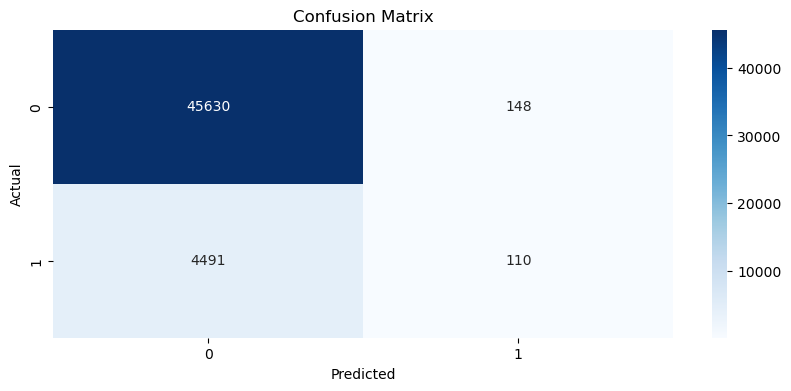

In [222]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [223]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6684
Recall: 0.5103
F1 Score: 0.4985


ROC AUC: 0.5103


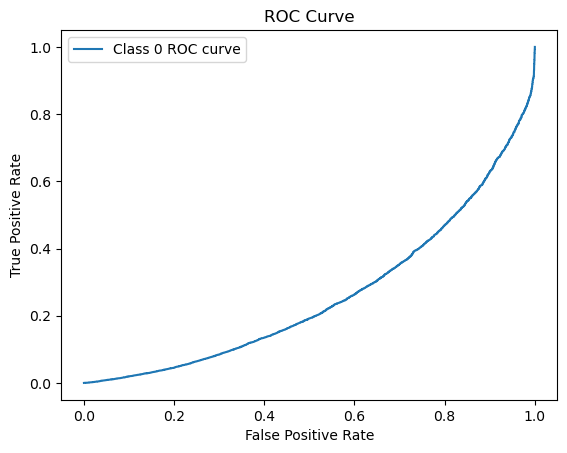

In [224]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 0, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Based on these metrics, the model kind of stinks! But, we can still implement it as a proof of concept. After evaluating some importance and a case study, we will revisit the model itself

Now let's see which variables are most important

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

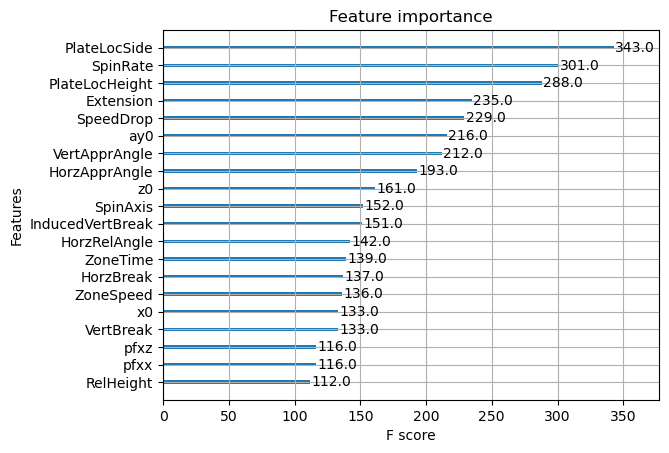

In [225]:
xgboost.plot_importance(model, max_num_features=20)

Now for a demonstration on calculating stuff+, let's select a few pitches from the data set, calculate their whiff percentage, and divide that by the average predicted whiff percentage for all the pitches

In [226]:
all_preds = model.predict_proba(fastballs_X)[:,1]
mean_pred = np.mean(all_preds)

print(mean_pred)

sample = fastballs_X.sample(n=10)

sample_preds = model.predict_proba(sample)[:,1]

stuff = sample_preds/mean_pred

print(stuff*100)

0.08966348
[ 61.26038   121.30586     2.1017108  64.3696    416.9105     77.31175
  13.465659  136.22362     5.8828626  69.12036  ]


Each of these values represents the Stuff+ for that pitch, defined by predicted whiff% / average whiff%. This will mean a lot more if we average all the values for each pitcher 

In [227]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

In [155]:
t_bauman = subsets['Bauman, Tanner']
t_bauman_X = t_bauman[preds]

whiff_preds = model.predict_proba(t_bauman_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Tanner Bauman fastball stuff+:{np.mean(stuff*100)}")

Tanner Bauman fastball stuff+:77.16925811767578


Now, this lumps in all of his fastballs. Let's see if he throws multiple types of fastballs and see how they all stack up

In [156]:
print(t_bauman['TaggedPitchType'].unique())

['Fastball' 'Sinker']


Seemingly he throws a sinker and a four-seamer. We can see how both of these stack up against all other fastballs. Obviously this is not ideal (we want to compare sinkers to sinkers, etc.) but it will do for now

In [157]:
t_bauman_sinks = t_bauman[t_bauman['TaggedPitchType']=='Sinker']
t_bauman_sinks_X = t_bauman_sinks[preds]

sink_whiff_pred = model.predict_proba(t_bauman_sinks_X)[:,1]

sink_stuff = np.mean(sink_whiff_pred/mean_pred)*100
print(sink_stuff)

94.22348141670227


We can do the same for his 'fastballs' (assuming four-seamer)

In [158]:
t_bauman_four = t_bauman[t_bauman['TaggedPitchType']=='Fastball']
t_bauman_four_X = t_bauman_four[preds]

four_whiff_pred = model.predict_proba(t_bauman_four_X)[:,1]

four_stuff = np.mean(four_whiff_pred/mean_pred)*100
print(four_stuff)

64.45404291152954


We can do the same thing for another selected pitcher

In [228]:
b_schorr = subsets['Schorr, Ben']
b_schorr_X = b_schorr[preds]

bs_whiff_preds = model.predict_proba(b_schorr_X)[:,1]

stuff = bs_whiff_preds/mean_pred

print(f"Ben Schorr fastball stuff+:{np.mean(stuff*100)}")

Ben Schorr fastball stuff+:73.8367919921875


In [229]:
print(b_schorr['TaggedPitchType'].unique())

['FourSeamFastBall' 'Cutter' 'Fastball']


In [230]:
b_schorr_cuts = b_schorr[b_schorr['TaggedPitchType']=='Cutter']
b_schorr_cuts_X = b_schorr_cuts[preds]

bs_cut_whiff_pred = model.predict_proba(b_schorr_cuts_X)[:,1]

bs_cut_stuff = np.mean(sink_whiff_pred/mean_pred)*100
print(sink_stuff)

94.22348141670227
